本文档参考 https://time.geekbang.org/course/detail/101054401-888795

## 0、前置准备

- 需安装如下依赖库:

pip install llama-index llama-index-llms-openai-like llama-index-embeddings-dashscope llama-index-readers-file

In [4]:
# --- 示例文档和问题 ---
documents = [
    Document(
        text="""
        大模型幻觉：指模型生成的内容看似真实，但实际上是虚构的，其成因主要有：
        1）数据问题：训练数据中可能包含存在歧义或表述有误的信息，导致模型学习到错误的知识
        2）模型结构限制：某些模型在处理复杂推理或长距离依赖关系时存在困难，可能导致生成不准确或虚构的内容
        3）上下文信息不足：在生成响应时，如果模型缺乏足够的上下文信息，可能无法理解问题的真实意图，从而生成与事实不符的内容
        ---- LlamaIndex相关介绍 ----
        LlamaIndex 是一个用于构建 LLM 应用程序的数据框架。
        它提供了一套工具，可以帮助开发者将私有数据与大型语言模型（LLMs）连接起来，
        实现包括问答、检索增强生成（RAG）等功能。
        LlamaIndex 支持多种数据源，包括 PDF、数据库、API 等。
        其核心概念包括文档加载器、节点解析器、索引和查询引擎。

        文档加载器负责将各种格式和来源的数据摄取到 LlamaIndex 中。
        节点解析器随后将这些加载的文档分解成更小、更易于管理的单元，称为节点。
        这些节点通常是句子或段落，具体取决于解析策略。
        索引是构建在这些节点之上的数据结构，旨在实现高效存储和检索，
        通常涉及向量嵌入以进行语义搜索。
        最后，查询引擎促进了与索引数据的交互，允许用户提出问题
        并利用 LLM 和检索到的信息合成答案。
        --- 以下是与 LlamaIndex 主题不太直接相关的内容 ---
        此外，Python 作为一门通用编程语言，其简洁性和丰富的库生态使其在 AI 领域广受欢迎。
        例如，NumPy 和 Pandas 是数据处理的基础，它们提供了强大的工具用于数值操作和结构化数据。
        Scikit-learn 则提供了全面的机器学习算法套件，适用于分类、回归和聚类等任务。
        这些工具共同构成了数据科学家和 AI 从业者的强大工具箱，
        使他们能够高效地开发和部署复杂的 AI 模型。
        --- 以下是另一个相关但概念上独立的部分 ---
        句子窗口切片是一种高级的切片策略，它在每个切片中包含一个目标句子，
        并在其前后添加一定数量的“窗口”句子作为上下文。
        这种方法旨在检索时为 LLM 提供丰富的局部上下文，从而提高生成答案的连贯性。
        语义切片则尝试根据文本的语义内容来划分段落，
        而不是仅仅依靠固定的字符数或句子数量。
        它利用嵌入模型计算句子或短语之间的语义相似度，
        识别出主题或含义发生自然转变的断点。
        这两种高级方法都能有效提升 RAG 应用的召回和生成质量。
        选择正确的切片策略通常取决于数据的具体特征和预期的查询类型。
        """
    )
]

In [17]:
# pip install llama-index llama-index-llms-openai-like llama-index-embeddings-dashscope llama-index-readers-file

import os
from llama_index.core import VectorStoreIndex, Settings, Document
from llama_index.core.node_parser import SentenceWindowNodeParser, SemanticSplitterNodeParser, TokenTextSplitter
from llama_index.embeddings.dashscope import DashScopeEmbedding
from llama_index.llms.openai_like import OpenAILike

# 导入 OpenAILike LLM (用于 DashScope 兼容模式，Qwen 模型)
# from llama_index.llms.openai_like import OpenAILike
# 导入 DashScopeEmbedding (用于阿里云 DashScope 嵌入模型)
# from llama_index.embeddings.dashscope import DashScopeEmbedding

# --- 配置阿里云 DashScope API Key ---
# 确保你的环境变量中设置了 DASHSCOPE_API_KEY
# 或者直接在这里设置（不推荐用于生产环境）：
# os.environ["DASHSCOPE_API_KEY"] = "sk-xxx"

# 获取 API Key
DASHSCOPE_API_KEY = os.getenv("DASHSCOPE_API_KEY")

# 初始化 LlamaIndex 全局设置

# 1. 配置 LLM (使用 DashScope 的 qwen-plus 模型，通过 OpenAILike 调用)
Settings.llm = OpenAILike(
    model="qwen-plus",
    api_base="https://dashscope.aliyuncs.com/compatible-mode/v1",
    api_key=DASHSCOPE_API_KEY,
    is_chat_model=True,
    temperature=0.1 # 添加温度参数，用于控制生成随机性
)

# 2. 配置嵌入模型 (使用 DashScopeEmbedding 类)
Settings.embed_model = DashScopeEmbedding(
    model_name="text-embedding-v4",
    api_key=DASHSCOPE_API_KEY,
)


def evaluate_splitter(splitter, documents, question, splitter_name):
    """
    评测不同文档切片方法的效果
    手动打印召回结果，方便直接对比切分效果。
    """
    print(f"\n{'='*50}")
    print(f"正在使用 {splitter_name} 方法进行测试...")
    print(f"{'='*50}\n")

    # 显示 raw chunks generated by the splitter
    print(f"【{splitter_name}】生成的原始文档切片 (Nodes):")
    raw_nodes = splitter.get_nodes_from_documents(documents)
    for i, node in enumerate(raw_nodes, 1):
        print(f"\n   切片 {i}, 长度: {len(node.get_content())}")
        if isinstance(splitter, SentenceWindowNodeParser):
            original_text = node.metadata.get("original_text", node.get_content())
            window_context = node.metadata.get("window", "N/A - 窗口内容未生成")
            print(f"   核心内容: \"{original_text}\"")
            print(f"   完整窗口上下文(供LLM用): \"{window_context}\"")
        else:
            print(f"   内容: \"{node.get_content()}\"")
        # Add metadata for debugging if needed
        # print(f"   元数据: {node.metadata}")
        print("   " + "-" * 40)
    print("\n" + "="*50)

    # # 构建索引
    # print("正在处理文档并构建索引...")
    # nodes = splitter.get_nodes_from_documents(documents)

    # index = VectorStoreIndex(nodes, embed_model=Settings.embed_model)

    # # 创建查询引擎
    # print("正在创建查询引擎...")
    # query_engine_params = {
    #     "similarity_top_k": 5,
    #     "streaming": True
    # }

    # # 如果是 Sentence Window 切片，添加后处理器
    # if isinstance(splitter, SentenceWindowNodeParser):
    #     query_engine_params["node_postprocessors"] = [
    #         MetadataReplacementPostProcessor(target_metadata_key="window")
    #     ]
    #     print("💡 检测到 Sentence Window 切片，已添加 MetadataReplacementPostProcessor。")

    # query_engine = index.as_query_engine(**query_engine_params)

    # # 执行查询
    # print(f"\n测试问题: {question}")
    # print("\n模型回答:")
    # response = query_engine.query(question)
    # response.print_response_stream()

    # # 输出召回的参考片段
    # print(f"\n{splitter_name} 召回的参考片段:")
    # if response.source_nodes:
    #     for i, node in enumerate(response.source_nodes, 1):
    #         print(f"\n--- 文档片段 {i} ---")

    #         # --- 优化后的打印逻辑 ---
    #         if isinstance(splitter, SentenceWindowNodeParser):
    #             # 对于Sentence Window，打印出窗口内容和原始中心句子
    #             window_content = node.metadata.get("window", "N/A - Window content missing")
    #             original_text = node.metadata.get("original_text", "N/A - Original text missing")
    #             print(f"【召回的窗口上下文】:\n{window_content}")
    #             print(f"\n【窗口中的核心句子】:\n{original_text}")
    #             # node.get_content() 在这里通常是核心句子
    #             # print(f"\n【Node Content (通常是核心句子)】:\n{node.get_content()}")
    #         else:
    #             # 对于其他切片器，直接打印节点内容
    #             print(f"【召回的文档内容】:\n{node.get_content()}")
    #         # --- 打印逻辑结束 ---

    #         print("-" * 50) # 分隔线

    # else:
    #     print("未召回任何文档片段。请检查文档内容或切片策略。")

    print(f"\n{splitter_name} 测试完成。")
    print(f"{'='*50}\n")

## 1、按Token切片

- 优点：
    - 实现简单，效率高，易于部署
    - 切块长度易于控制，方便后续与向量检索系统对接
- 缺点：
   - 容易打断语句或词语，影响语义完整性
   - 某些块上下文不连续，影响 LLM 理解效果
- 适用场景：
   - 数据量大、需快速预处理时
   - 文本语义关联性弱的场景

- 基于前置准备,测试按照Token切片

In [18]:
question = "LlamaIndex 的主要功能和核心概念是什么？以及两种高级切片策略的区别？"

# --- 开始测试不同的切片策略 ---
# Token 切片 (Character/Token-based)
# token_splitter = TokenTextSplitter(
#     chunk_size=30, # Small chunk size to demonstrate forced breaks
#     chunk_overlap=0 # No overlap for clear distinct chunks
# )
# evaluate_splitter(token_splitter, documents, question, "Token 切片 (chunk_size=30)")

token_splitter = TokenTextSplitter(
    chunk_size=50, # Small chunk size to demonstrate forced breaks
    chunk_overlap=20 # No overlap for clear distinct chunks
)
evaluate_splitter(token_splitter, documents, question, "Token 切片 (chunk_size=50,chunk_overlap=20 )")


# 文档原文: [.....内容X..... | 内容Y | .....内容Z.....]
#                      ↑           ↑
#                      切块A末尾    切块B起始点 (从切块A末尾往前50个字符)

# 切块A: [.....内容X..... | 内容Y] (512个字符)
# 切块B:                 [内容Y | .....内容Z.....] (512个字符)



正在使用 Token 切片 (chunk_size=50,chunk_overlap=20 ) 方法进行测试...

【Token 切片 (chunk_size=50,chunk_overlap=20 )】生成的原始文档切片 (Nodes):
Metadata length (2) is close to chunk size (50). Resulting chunks are less than 50 tokens. Consider increasing the chunk size or decreasing the size of your metadata to avoid this.

   切片 1, 长度: 35
   内容: "大模型幻觉：指模型生成的内容看似真实，但实际上是虚构的，其成因主要有："
   ----------------------------------------

   切片 2, 长度: 41
   内容: "1）数据问题：训练数据中可能包含存在歧义或表述有误的信息，导致模型学习到错误的知识"
   ----------------------------------------

   切片 3, 长度: 32
   内容: "2）模型结构限制：某些模型在处理复杂推理或长距离依赖关系时存在困"
   ----------------------------------------

   切片 4, 长度: 31
   内容: "推理或长距离依赖关系时存在困难，可能导致生成不准确或虚构的内容"
   ----------------------------------------

   切片 5, 长度: 42
   内容: "成不准确或虚构的内容
        3）上下文信息不足：在生成响应时，如果模型缺乏"
   ----------------------------------------

   切片 6, 长度: 42
   内容: "不足：在生成响应时，如果模型缺乏足够的上下文信息，可能无法理解问题的真实意图，从而生"
   ----------------------------------------

   切片 7, 长度: 62
   内容: "信息，可能无法理解问题的真实意图，从而生成与

## 2、按句子切片

- 优点:
   - 能保留基本语义结构,每个分块的内容自然流畅
   - 有助于信息检索和 LLM 理解
- 缺点:
   - 块长度难以严格控制，长度分布不均
   - 某些极长段落仍需特殊处理
- 适用场景:
   - 希望尽可能保留原始语义边界的场景,如法律、论文、长文本
   - 对上下文连续性有一定要求

- 基于前置准备,测试按照句子切片

In [19]:
from llama_index.core.node_parser import SentenceSplitter

question = "LlamaIndex 的主要功能和核心概念是什么？以及两种高级切片策略的区别？"
# --- 开始测试句子切分 ---
sentence_splitter = SentenceSplitter(
    chunk_size=100,
    chunk_overlap=20
)
evaluate_splitter(sentence_splitter, documents, question, "Sentence")



正在使用 Sentence 方法进行测试...

【Sentence】生成的原始文档切片 (Nodes):

   切片 1, 长度: 85
   内容: "大模型幻觉：指模型生成的内容看似真实，但实际上是虚构的，其成因主要有：
        1）数据问题：训练数据中可能包含存在歧义或表述有误的信息，导致模型学习到错误的知识"
   ----------------------------------------

   切片 2, 长度: 49
   内容: "2）模型结构限制：某些模型在处理复杂推理或长距离依赖关系时存在困难，可能导致生成不准确或虚构的内容"
   ----------------------------------------

   切片 3, 长度: 122
   内容: "3）上下文信息不足：在生成响应时，如果模型缺乏足够的上下文信息，可能无法理解问题的真实意图，从而生成与事实不符的内容
        ---- LlamaIndex相关介绍 ----
        LlamaIndex 是一个用于构建 LLM"
   ----------------------------------------

   切片 4, 长度: 125
   内容: "----
        LlamaIndex 是一个用于构建 LLM 应用程序的数据框架。
        它提供了一套工具，可以帮助开发者将私有数据与大型语言模型（LLMs）连接起来，
        实现包括问答、检索增强生成（RAG）等功能。"
   ----------------------------------------

   切片 5, 长度: 117
   内容: "LlamaIndex 支持多种数据源，包括 PDF、数据库、API 等。
        其核心概念包括文档加载器、节点解析器、索引和查询引擎。

        文档加载器负责将各种格式和来源的数据摄取到 LlamaIndex 中。"
   ----------------------------------------

   切片 6, 长度: 67
   内容: "节点解析器随后将这些加载的文档分解成更小、更易于管理的单元，称为节点。
        这些节点通常是句子或段落，具体取决于解析

## 3、句子窗口切片

- 基于前置准备,测试句子窗口切片

In [20]:
question = "LlamaIndex 的主要功能和核心概念是什么？以及两种高级切片策略的区别？"

# --- 开始测试句子窗口切片 ---

# 句子窗口切片 (Sentence Window)
sentence_window_splitter = SentenceWindowNodeParser.from_defaults(
    window_size=2,
    window_metadata_key="window",
    original_text_metadata_key="original_text"
)
evaluate_splitter(sentence_window_splitter, documents, question, "Sentence Window")


正在使用 Sentence Window 方法进行测试...

【Sentence Window】生成的原始文档切片 (Nodes):

   切片 1, 长度: 1346
   核心内容: "
        大模型幻觉：指模型生成的内容看似真实，但实际上是虚构的，其成因主要有：
        1）数据问题：训练数据中可能包含存在歧义或表述有误的信息，导致模型学习到错误的知识
        2）模型结构限制：某些模型在处理复杂推理或长距离依赖关系时存在困难，可能导致生成不准确或虚构的内容
        3）上下文信息不足：在生成响应时，如果模型缺乏足够的上下文信息，可能无法理解问题的真实意图，从而生成与事实不符的内容
        ---- LlamaIndex相关介绍 ----
        LlamaIndex 是一个用于构建 LLM 应用程序的数据框架。
        它提供了一套工具，可以帮助开发者将私有数据与大型语言模型（LLMs）连接起来，
        实现包括问答、检索增强生成（RAG）等功能。
        LlamaIndex 支持多种数据源，包括 PDF、数据库、API 等。
        其核心概念包括文档加载器、节点解析器、索引和查询引擎。

        文档加载器负责将各种格式和来源的数据摄取到 LlamaIndex 中。
        节点解析器随后将这些加载的文档分解成更小、更易于管理的单元，称为节点。
        这些节点通常是句子或段落，具体取决于解析策略。
        索引是构建在这些节点之上的数据结构，旨在实现高效存储和检索，
        通常涉及向量嵌入以进行语义搜索。
        最后，查询引擎促进了与索引数据的交互，允许用户提出问题
        并利用 LLM 和检索到的信息合成答案。
        --- 以下是与 LlamaIndex 主题不太直接相关的内容 ---
        此外，Python 作为一门通用编程语言，其简洁性和丰富的库生态使其在 AI 领域广受欢迎。
        例如，NumPy 和 Pandas 是数据处理的基础，它们提供了强大的工具用于数值操作和结构化数据。
        Scikit-learn 则提供了全面的机器学习算法套件，适用

## 4、句子滑动窗口切片

- 优点:
  - 上下文保留: 可设置合理的chunk_overlap确保切块边界的信息不会丢失,有效缓解了“答案在切块边缘”的问题
      保证块间上下文连贯,减小语义割裂影响
  - 大小可控: 可大致控制切块的chunk_size,对LLM的上下文窗口友好
  - 速度快: 不依赖昂贵的Embedding模型调用,计算成本低
- 缺点:
  - 语义盲目: 完全不理解文本内容,可能在逻辑最紧密的地方强行切分,导致"语义割裂"
  - 冗余度高: 产生大量重叠内容,增加了索引的存储成本和检索时的计算量
- 适用场景:
  - 需要提升检索覆盖率、保证上下文连续时
  - 适用于 FAQ、知识库等高相关上下文场景

In [16]:
def demonstrate_sliding_window_splitter(documents, chunk_size, chunk_overlap):
    """
    演示 LlamaIndex 中保持句子完整性的滑动窗口切片。

    Args:
        documents (list[Document]): 待切分的文档列表。
        chunk_size (int): 每个切块的目标 Token 数量。
        chunk_overlap (int): 相邻切块之间重叠的 Token 数量。
    """
    print(f"\n{'='*50}")
    print(f"正在演示【滑动窗口切片】...")
    print(f"切块大小 (chunk_size): {chunk_size}")
    print(f"重叠大小 (chunk_overlap): {chunk_overlap}")
    print(f"{'='*50}\n")

    # --- 第一步：创建切分器 ---
    # SentenceSplitter 优先保持句子完整性，再考虑大小
    splitter = SentenceSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )

    # --- 第二步：执行切分 ---
    # 获取切分后的节点（切块）
    nodes = splitter.get_nodes_from_documents(documents)

    # --- 第三步：打印切分结果，展示重叠效果 ---
    print("\n--- 切分后生成的原始切块：---")
    print(f"文档被切分为 {len(nodes)} 个切块。")
    for i, node in enumerate(nodes, 1):
        content = node.get_content().strip()
        print(f"\n【切块 {i}】 (长度: {len(content)} 字符):")
        print("-" * 50)
        print(f"内容:\n\"{content}\"")
        print("-" * 50)

    # --- 简单的切分效果分析：观察相邻切块的重叠部分 ---
    print("\n--- 关键点：观察相邻切块的重叠部分 ---")
    if len(nodes) > 1:
        # 为了更好地展示重叠，我们只截取重叠部分的内容
        # 由于是句子级别的切分，重叠部分是完整的句子
        overlap_content_end_of_chunk1 = nodes[0].get_content()[-chunk_overlap:].strip()
        overlap_content_start_of_chunk2 = nodes[1].get_content()[:chunk_overlap].strip()
        print(f"切块 1 的末尾 ({chunk_overlap} 字符): \"...{overlap_content_end_of_chunk1}\"")
        print(f"切块 2 的开头 ({chunk_overlap} 字符): \"{overlap_content_start_of_chunk2}...\"")
        print(f"\n你可以看到，切块 1 的末尾与切块 2 的开头存在重叠，这就是 chunk_overlap 的作用。")
    else:
        print("文档太短，未能生成多个切块。请使用更长的文档以观察效果。")

    print(f"\n滑动窗口切片测试完成。")
    print(f"{'='*50}\n")

# --- 调用滑动窗口切片演示函数 ---
# 调整 chunk_size 和 chunk_overlap 观察不同效果
demonstrate_sliding_window_splitter(documents, chunk_size=150, chunk_overlap=50)


正在演示【滑动窗口切片】...
切块大小 (chunk_size): 150
重叠大小 (chunk_overlap): 50


--- 切分后生成的原始切块：---
文档被切分为 11 个切块。

【切块 1】 (长度: 85 字符):
--------------------------------------------------
内容:
"大模型幻觉：指模型生成的内容看似真实，但实际上是虚构的，其成因主要有：
        1）数据问题：训练数据中可能包含存在歧义或表述有误的信息，导致模型学习到错误的知识"
--------------------------------------------------

【切块 2】 (长度: 99 字符):
--------------------------------------------------
内容:
"1）数据问题：训练数据中可能包含存在歧义或表述有误的信息，导致模型学习到错误的知识
        2）模型结构限制：某些模型在处理复杂推理或长距离依赖关系时存在困难，可能导致生成不准确或虚构的内容"
--------------------------------------------------

【切块 3】 (长度: 133 字符):
--------------------------------------------------
内容:
"3）上下文信息不足：在生成响应时，如果模型缺乏足够的上下文信息，可能无法理解问题的真实意图，从而生成与事实不符的内容
        ---- LlamaIndex相关介绍 ----
        LlamaIndex 是一个用于构建 LLM 应用程序的数据框架。"
--------------------------------------------------

【切块 4】 (长度: 190 字符):
--------------------------------------------------
内容:
"---- LlamaIndex相关介绍 ----
        LlamaIndex 是一个用于构建 LLM 应用程序的数据框架。
        它提供了一套工具，可以帮助开发者将私有数据与大型语言模型（LLMs）连接起来

## 5、语义切片

- 语义切分:
    - 本质是"找语义边界",通过句子嵌入的相似度,判断相邻句子是否属于同一语义块,相似度低于阈值则视为边界,进行切分,高于阈值则不切分
    - 为避免切分太生硬,可设置参数buffer_size(切分点前后保留句子的个数)
    - 自定义中文分句是适配中文场景的关键,可视化则能直观验证切分效果

- 优点:
    - 语义完整性: 切块的边界就是语义的边界，每个块都是一个高度内聚的、完整的逻辑单元
    - 信噪比高: 提供给LLM的上下文非常“干净”,几乎没有无关信息
    - 动态大小: 切块大小自适应文本的逻辑结构
- 缺点:
    - 边界上下文丢失: 如果用户的答案恰好需要结合两个语义块边界的信息，可能会因为没有重叠而检索不全
    - 大小不可控: 可能产生非常大的语义块，超出LLM能处理的上下文长度限制
    - 成本高: 需要为每个句子计算嵌入向量，速度慢且有API调用成本
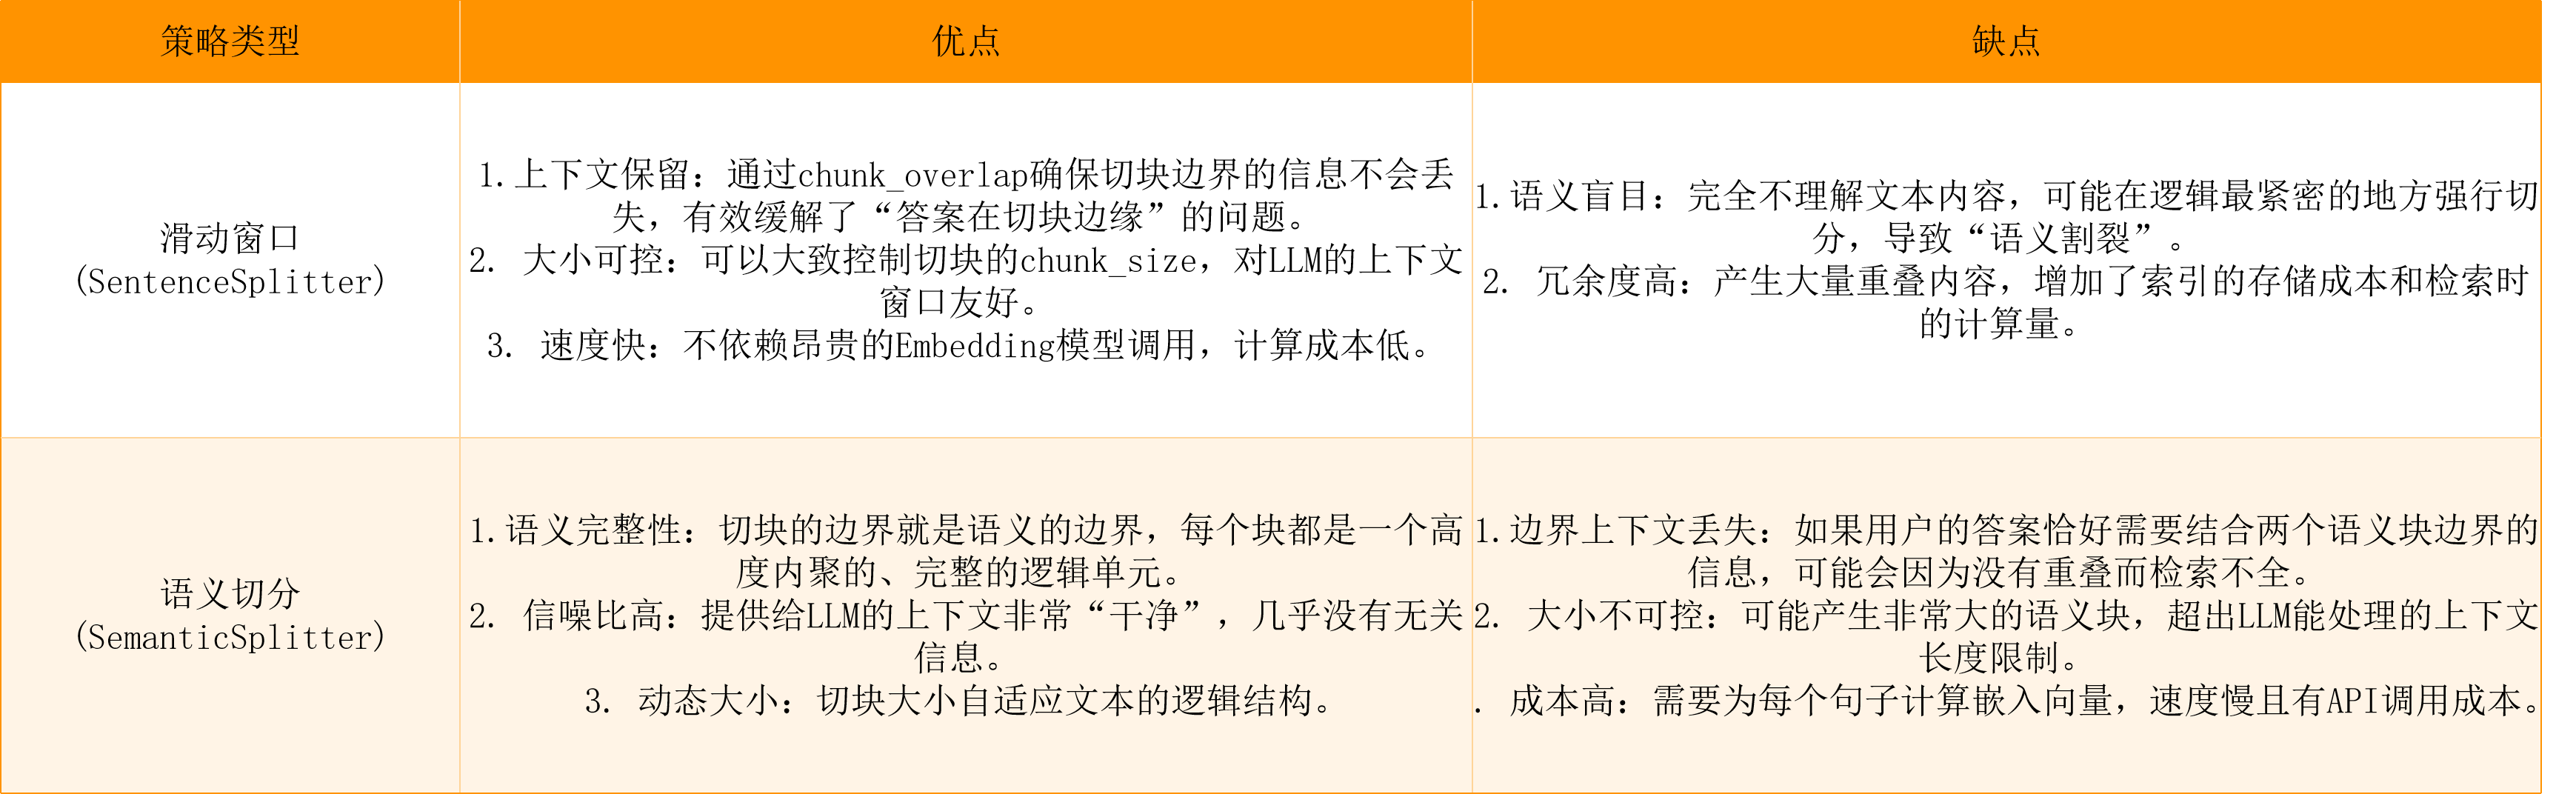

==================== 实验一：使用保守阈值 (95) ====================
正在为 16 个句子生成嵌入向量...


Generating embeddings:   0%|          | 0/16 [00:00<?, ?it/s]

计算出的相似度阈值为: 0.5508


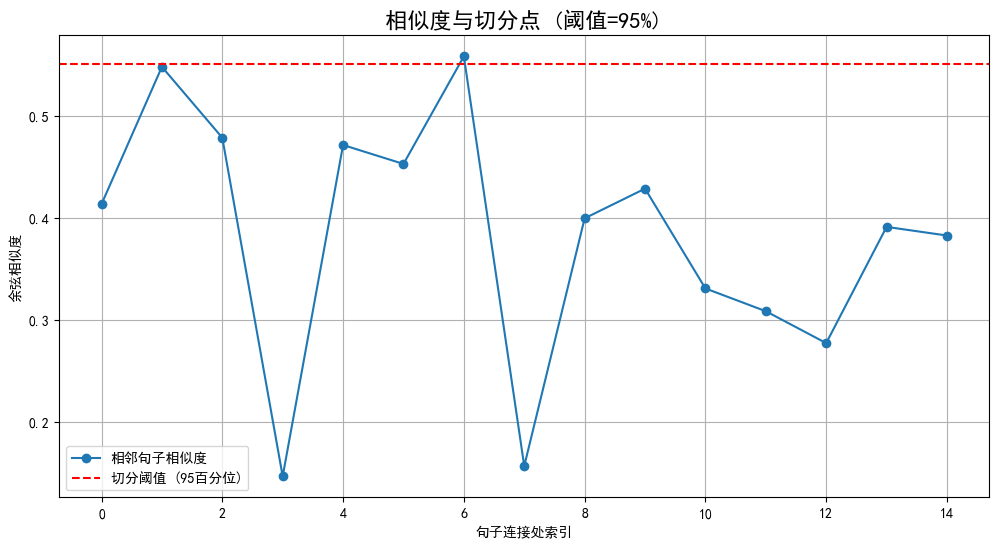


--- 切分结果 ---
====== 节点 1 (长度: 59 tokens) ======
大语言模型（LLM）是人工智能领域的一项革命性技术。其发展可以追溯到早期的神经网络和自然语言处理研究。
--------------------
====== 节点 2 (长度: 505 tokens) ======
最初的模型，如循环神经网络（RNN），在处理长序列文本时遇到了梯度消失的问题。随后，长短期记忆网络（LSTM）在一定程度上缓解了这个问题，但仍然存在局限性。真正的突破来自于2017年提出的Transformer架构。Transformer模型完全基于自注意力机制（Self-Attention），能够并行处理文本序列，极大地提高了训练效率和模型性能。这为构建更大、更深的模型（如BERT和GPT系列）奠定了基础。BERT使用双向编码器，在理解上下文方面表现出色，而GPT则采用自回归解码器，在文本生成方面尤为强大。如今，LLM的应用已经渗透到各行各业。它们不仅能进行智能问答、内容创作和代码生成，还在医疗、金融和教育等领域展现出巨大潜力。例如，在医疗领域，LLM可以帮助医生分析病历、提供诊断建议。在教育领域，它可以为学生提供个性化的辅导和学习资源。然而，LLM的发展也伴随着挑战。模型的偏见、幻觉问题以及高昂的计算成本都是亟待解决的难题。未来的研究方向可能包括提高模型的效率、增强其可解释性，并建立更负责任的人工智能治理框架。确保技术的普惠和安全是所有研究者共同的责任。
--------------------

==================== 实验二：使用激进阈值 (5) ====================
正在为 16 个句子生成嵌入向量...


Generating embeddings:   0%|          | 0/16 [00:00<?, ?it/s]

计算出的相似度阈值为: 0.1534


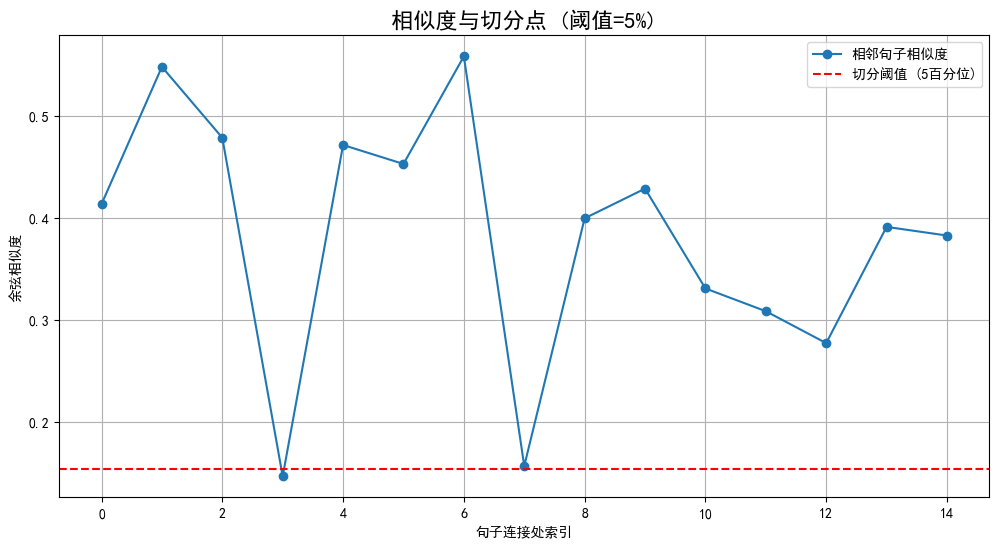


--- 切分结果 ---
====== 节点 1 (长度: 59 tokens) ======
大语言模型（LLM）是人工智能领域的一项革命性技术。其发展可以追溯到早期的神经网络和自然语言处理研究。
--------------------
====== 节点 2 (长度: 39 tokens) ======
最初的模型，如循环神经网络（RNN），在处理长序列文本时遇到了梯度消失的问题。
--------------------
====== 节点 3 (长度: 40 tokens) ======
随后，长短期记忆网络（LSTM）在一定程度上缓解了这个问题，但仍然存在局限性。
--------------------
====== 节点 4 (长度: 22 tokens) ======
真正的突破来自于2017年提出的Transformer架构。
--------------------
====== 节点 5 (长度: 47 tokens) ======
Transformer模型完全基于自注意力机制（Self-Attention），能够并行处理文本序列，极大地提高了训练效率和模型性能。
--------------------
====== 节点 6 (长度: 30 tokens) ======
这为构建更大、更深的模型（如BERT和GPT系列）奠定了基础。
--------------------
====== 节点 7 (长度: 48 tokens) ======
BERT使用双向编码器，在理解上下文方面表现出色，而GPT则采用自回归解码器，在文本生成方面尤为强大。
--------------------
====== 节点 8 (长度: 22 tokens) ======
如今，LLM的应用已经渗透到各行各业。
--------------------
====== 节点 9 (长度: 56 tokens) ======
它们不仅能进行智能问答、内容创作和代码生成，还在医疗、金融和教育等领域展现出巨大潜力。
--------------------
====== 节点 10 (长度: 37 tokens) ======
例如，在医疗领域，LLM可以帮助医生分析病历、提供诊断建议。
--------------------
====== 节点 11 (长

In [22]:
import numpy as np  # 算术运算,用于计算余弦相似度、百分位阈值
import re  # 正则匹配中文句末标点,实现中文分句
import matplotlib.pyplot as plt   # 可视化相邻句子相似度和切分阈值
from llama_index.core import get_tokenizer

# 流程: 自定义中文分句 → 配置语义切分器 → 计算句子嵌入与相似度 → 可视化相似度 + 阈值 → 实际切分文本 → 输出切分结果
# --- 1. 全局配置 ---
# DASHSCOPE_API_KEY = os.getenv("DASHSCOPE_API_KEY")
DASHSCOPE_BASE_URL = "https://dashscope.aliyuncs.com/compatible-mode/v1"
# --- 2. 初始化 LlamaIndex 全局设置 ---
Settings.llm = OpenAILike(model="qwen-plus", api_base=DASHSCOPE_BASE_URL, api_key=DASHSCOPE_API_KEY, is_chat_model=True, temperature=0.1)
Settings.embed_model = DashScopeEmbedding(model_name="text-embedding-v2", api_key=DASHSCOPE_API_KEY, batch_size=10)
llama_tokenizer = get_tokenizer()

# --- 3. 定义一个能处理中文的自定义分句函数 ---
# 这个函数本身就是 SemanticSplitterNodeParser 所需要的"句子切分器"
def chinese_sentence_tokenizer(text: str) -> list[str]:
    sentences = re.findall(r'[^。！？…\n]+[。！？…\n]?', text)
    return [s.strip() for s in sentences if s.strip()]

# --- 4. 准备长文本 ---
long_text = (
    "大语言模型（LLM）是人工智能领域的一项革命性技术。其发展可以追溯到早期的神经网络和自然语言处理研究。最初的模型，如循环神经网络（RNN），在处理长序列文本时遇到了梯度消失的问题。随后，长短期记忆网络（LSTM）在一定程度上缓解了这个问题，但仍然存在局限性。\n\n"
    "真正的突破来自于2017年提出的Transformer架构。Transformer模型完全基于自注意力机制（Self-Attention），能够并行处理文本序列，极大地提高了训练效率和模型性能。这为构建更大、更深的模型（如BERT和GPT系列）奠定了基础。BERT使用双向编码器，在理解上下文方面表现出色，而GPT则采用自回归解码器，在文本生成方面尤为强大。\n\n"
    "如今，LLM的应用已经渗透到各行各业。它们不仅能进行智能问答、内容创作和代码生成，还在医疗、金融和教育等领域展现出巨大潜力。例如，在医疗领域，LLM可以帮助医生分析病历、提供诊断建议。在教育领域，它可以为学生提供个性化的辅导和学习资源。\n\n"
    "然而，LLM的发展也伴随着挑战。模型的偏见、幻觉问题以及高昂的计算成本都是亟待解决的难题。未来的研究方向可能包括提高模型的效率、增强其可解释性，并建立更负责任的人工智能治理框架。确保技术的普惠和安全是所有研究者共同的责任。"
)
document = Document(text=long_text)

def plot_similarity_and_chunks(splitter: SemanticSplitterNodeParser, title: str):
    # 使用我们自己的函数进行可视化部分的句子切分，这部分逻辑是正确的
    sentences = chinese_sentence_tokenizer(document.get_content())

    if len(sentences) < 2:
        print(f"错误：只找到了 {len(sentences)} 个句子，无法计算句子间的相似度。")
        return

    print(f"正在为 {len(sentences)} 个句子生成嵌入向量...")
    embeddings = Settings.embed_model.get_text_embedding_batch(sentences, show_progress=True)

    def cosine_similarity(v1, v2):
        return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    # 计算相邻句子的余弦相似度（范围0~1，1=完全相似，0=完全无关）
    similarities = [cosine_similarity(embeddings[i], embeddings[i+1]) for i in range(len(embeddings) - 1)]
    # 计算切分阈值:基于百分位(核心参数)
    breakpoint_threshold_val = np.percentile(similarities, splitter.breakpoint_percentile_threshold)
    print(f"计算出的相似度阈值为: {breakpoint_threshold_val:.4f}")

    # --- 可视化 ---
    plt.figure(figsize=(12, 6))
    plt.plot(similarities, marker='o', linestyle='-', label='相邻句子相似度')
    plt.axhline(y=breakpoint_threshold_val, color='r', linestyle='--', label=f'切分阈值 ({splitter.breakpoint_percentile_threshold}百分位)')
    plt.title(title, fontsize=16)
    plt.xlabel("句子连接处索引")
    plt.ylabel("余弦相似度")
    plt.legend()
    try:
        plt.rcParams['font.sans-serif'] = ['SimHei']
        plt.rcParams['axes.unicode_minus'] = False
    except Exception:
        print("无法设置中文字体 'SimHei'，图表中的中文可能显示为乱码。")
    plt.grid(True)
    plt.show()

    # --- 实际切分 ---
    # 这部分现在应该可以正常工作了
    nodes = splitter.get_nodes_from_documents([document])
    print("\n--- 切分结果 ---")
    for i, node in enumerate(nodes):
        print(f"====== 节点 {i+1} (长度: {len(llama_tokenizer(node.get_content()))} tokens) ======")
        print(node.get_content().strip())
        print("-" * 20)

# --- 5. 直接将我们编写的函数传递给 SemanticSplitterNodeParser

# 实验一：使用保守阈值 (95)
print("="*20 + " 实验一：使用保守阈值 (95) " + "="*20)
conservative_splitter = SemanticSplitterNodeParser(
    buffer_size=1,
    breakpoint_percentile_threshold=95,  # 切分阈值(百分位):值越高,切分越保守;值越低,切分越激进
    embed_model=Settings.embed_model,
    sentence_splitter=chinese_sentence_tokenizer
)
plot_similarity_and_chunks(conservative_splitter, "相似度与切分点 (阈值=95%)")


# 实验二：使用激进阈值 (5)
print("\n" + "="*20 + " 实验二：使用激进阈值 (5) " + "="*20)
aggressive_splitter = SemanticSplitterNodeParser(
    buffer_size=1,
    breakpoint_percentile_threshold=5,
    embed_model=Settings.embed_model,
    sentence_splitter=chinese_sentence_tokenizer
)
plot_similarity_and_chunks(aggressive_splitter, "相似度与切分点 (阈值=5%)")

## 6、关键词语义+滑动窗口切片

- 优点:
   - 兼顾语义与长度可控,稳定性强
   - 适应复杂文档和海量数据,灵活应对各种结构
- 缺点:
   - 实现复杂,参数和阈值需反复调整
   - 某些极端文档结构仍需人工干预
- 适用场景:
   - 需要对各种类型文本都具备良好切块效果
   - 追求召回率与精度最佳平衡的生产应用

In [26]:
import os,re
import textwrap # 导入 textwrap 模块
from typing import List, Callable
from pydantic import Field
from llama_index.core import Settings, Document
from llama_index.core.node_parser import NodeParser, SentenceSplitter, SemanticSplitterNodeParser
from llama_index.llms.openai_like import OpenAILike
from llama_index.embeddings.dashscope import DashScopeEmbedding
from llama_index.core.utils import get_tokenizer

DASHSCOPE_API_KEY = os.getenv("DASHSCOPE_API_KEY")
DASHSCOPE_BASE_URL = "https://dashscope.aliyuncs.com/compatible-mode/v1"
# --- 自定义混合解析器类 (已更新为带详细打印的版本) ---
class HybridNodeParser(NodeParser):
    primary_parser: NodeParser
    secondary_parser: NodeParser
    max_chunk_size: int = 1024
    tokenizer: Callable = Field(default_factory=get_tokenizer, exclude=True)

    def _parse_nodes(self, documents: List[Document], **kwargs) -> List[Document]:
        print("--- 开始执行【混合切分】... ---")

        primary_nodes = self.primary_parser.get_nodes_from_documents(documents)
        print(f"\n{'='*25} 第一步（语义切分）结果 {'='*25}")
        print(f"初步切分出 {len(primary_nodes)} 个语义段落。")
        for i, p_node in enumerate(primary_nodes, 1):
            print(f"\n【原始语义段落 {i}】 (大小: {len(self.tokenizer(p_node.get_content()))} tokens)")
            print("-" * 60)
            print(textwrap.indent(p_node.get_content().strip(), '  '))
            print("-" * 60)

        print(f"\n{'='*25} 第二步（检查与二次切分）过程 {'='*25}")
        final_nodes = []
        for i, node in enumerate(primary_nodes, 1):
            node_size = len(self.tokenizer(node.get_content()))
            print(f"\n>>> 正在检查【原始语义段落 {i}】 (大小: {node_size} tokens)...")

            if node_size <= self.max_chunk_size:
                print(f"  └── 结果: 大小合适 (<= {self.max_chunk_size} tokens)，直接采纳。")
                final_nodes.append(node)
            else:
                print(f"  └── 结果: 段落过大 (> {self.max_chunk_size} tokens)，将使用滑动窗口进行二次切分。")
                print("\n      【即将被切分的原始内容】")
                print("      " + "-"*50)
                print(textwrap.indent(node.get_content().strip(), '      | '))
                print("      " + "-"*50)

                sub_nodes = self.secondary_parser.get_nodes_from_documents([Document(text=node.get_content())])
                print(f"\n      【二次切分结果】: 被切分成了 {len(sub_nodes)} 个重叠的子切块。")
                for j, s_node in enumerate(sub_nodes, 1):
                    print(f"\n        【子切块 {i}.{j}】 (大小: {len(self.tokenizer(s_node.get_content()))} tokens)")
                    print("        " + "-"*40)
                    print(textwrap.indent(s_node.get_content().strip(), '        | '))
                    print("        " + "-"*40)

                final_nodes.extend(sub_nodes)

        print("\n--- 【混合切分】完成！---")
        return final_nodes

    @classmethod
    def from_defaults(cls, **kwargs):
        raise NotImplementedError("请直接实例化此类，不要使用 from_defaults")

# --- 全局配置 --
Settings.llm = OpenAILike(model="qwen-plus", api_base=DASHSCOPE_BASE_URL, api_key=DASHSCOPE_API_KEY, is_chat_model=True, temperature=0.1)
Settings.embed_model = DashScopeEmbedding(model_name="text-embedding-v2", api_key=DASHSCOPE_API_KEY, batch_size=10)

# --- 中文分句函数 ---
def chinese_sentence_tokenizer(text: str) -> list[str]:
    sentences = re.findall(r'[^。！？…\n]+[。！？…\n]?', text)
    return [s.strip() for s in sentences if s.strip()]

# --- 准备长文档 ---
long_document = Document(
    text="""
    LlamaIndex 是一个用于构建、评估和部署高级 RAG（检索增强生成）应用程序的数据框架。它的核心使命是帮助开发者将私有或领域特定的数据与大型语言模型（LLMs）无缝连接。通过提供数据连接器、索引结构、查询引擎和评估工具，LlamaIndex 极大地简化了从原始数据到生产级 RAG 应用的全过程。它支持上百种数据源，包括 PDF 文件、数据库、Notion 页面以及各种 API，确保了数据接入的灵活性。

    在技术架构上，LlamaIndex 的设计哲学是模块化和可扩展性。其核心组件包括文档加载器（Document Loaders）、节点解析器（Node Parsers）、索引（Indices）、检索器（Retrievers）和查询引擎（Query Engines）。文档加载器负责从不同来源摄取数据。节点解析器（如我们正在讨论的这些）将加载的文档分解成更小、更易于管理的“节点”（Nodes），这是构建索引的基础单元。索引结构，特别是向量索引，利用嵌入模型将节点转换为高维向量，从而实现高效的语义搜索和检索。检索器则根据用户查询从索引中找出最相关的节点。最后，查询引擎协调检索器和 LLM，生成最终的、富有上下文的答案。这套架构使得开发者可以像搭乐高一样，自由组合和定制自己的 RAG 管道。

    评估是 LlamaIndex 另一个强大的功能。它提供了一整套工具来量化 RAG 应用的性能，包括答案的忠实度（Faithfulness）、相关性（Relevancy）以及上下文检索的准确率和召回率。通过这些量化指标，开发者可以系统地调试和优化他们的应用，而不仅仅是凭感觉。
    """
)

# --- 实例化两个基础的解析器 ---
semantic_parser = SemanticSplitterNodeParser(
    buffer_size=1,
    breakpoint_percentile_threshold=95,
    sentence_splitter=chinese_sentence_tokenizer,
    embed_model=Settings.embed_model
)
window_parser = SentenceSplitter(
    chunk_size=256,
    chunk_overlap=50
)

# --- 实例化并使用我们的混合解析器  ---
hybrid_parser = HybridNodeParser(
    primary_parser=semantic_parser,
    secondary_parser=window_parser,
    max_chunk_size=300,
    tokenizer=get_tokenizer()
)

# 执行混合切分
final_nodes = hybrid_parser.get_nodes_from_documents([long_document])

# --- 打印最终结果  ---
print(f"\n{'='*25} 最终生成的切块列表 {'='*25}")
print(f"切块总数: {len(final_nodes)}")
for i, node in enumerate(final_nodes, 1):
    content = node.get_content().strip()
    print(f"\n【最终切块 {i}】:")
    print("-" * 50)
    print(textwrap.indent(content, '  '))
    print("-" * 50)

--- 开始执行【混合切分】... ---

========================= 第一步（语义切分）结果 =========================
初步切分出 2 个语义段落。

【原始语义段落 1】 (大小: 254 tokens)
------------------------------------------------------------
  LlamaIndex 是一个用于构建、评估和部署高级 RAG（检索增强生成）应用程序的数据框架。它的核心使命是帮助开发者将私有或领域特定的数据与大型语言模型（LLMs）无缝连接。通过提供数据连接器、索引结构、查询引擎和评估工具，LlamaIndex 极大地简化了从原始数据到生产级 RAG 应用的全过程。它支持上百种数据源，包括 PDF 文件、数据库、Notion 页面以及各种 API，确保了数据接入的灵活性。在技术架构上，LlamaIndex 的设计哲学是模块化和可扩展性。其核心组件包括文档加载器（Document Loaders）、节点解析器（Node Parsers）、索引（Indices）、检索器（Retrievers）和查询引擎（Query Engines）。
------------------------------------------------------------

【原始语义段落 2】 (大小: 327 tokens)
------------------------------------------------------------
  文档加载器负责从不同来源摄取数据。节点解析器（如我们正在讨论的这些）将加载的文档分解成更小、更易于管理的“节点”（Nodes），这是构建索引的基础单元。索引结构，特别是向量索引，利用嵌入模型将节点转换为高维向量，从而实现高效的语义搜索和检索。检索器则根据用户查询从索引中找出最相关的节点。最后，查询引擎协调检索器和 LLM，生成最终的、富有上下文的答案。这套架构使得开发者可以像搭乐高一样，自由组合和定制自己的 RAG 管道。评估是 LlamaIndex 另一个强大的功能。它提供了一整套工具来量化 RAG 应用的性能，包括答案的忠实度（Faithfulness）、相关性（Relevancy）以及上下文检索的准确率和召回率。通

- 小结:
    - 1）在实际应用中,选择切片方法不必拘泥于某一种模式
    - 2）没有“最好的”切片方法,只有“最适合当前任务”的方法
    - 3）建议多尝试几种策略,观察每种策略在检索和生成上的表现差异,找到最适合业务场景的方案